In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from kneed import KneeLocator
import squarify
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
# Specify the file path for the Excel file containing retail data
file_path = '/content/online_retail_II.xlsx'

# Load data from the first sheet (Year 2009-2010) of the Excel file
sheet1 = pd.read_excel(file_path, sheet_name='Year 2009-2010')

# Load data from the second sheet (Year 2010-2011) of the Excel file
sheet2 = pd.read_excel(file_path, sheet_name='Year 2010-2011')

# Concatenate the data from both sheets into a single DataFrame, resetting the index
data = pd.concat([sheet1, sheet2], ignore_index=True)


In [ ]:
# Display the first five rows of the DataFrame to preview the data
print(data.head())

# Print the number of rows and columns in the DataFrame
print(data.shape)

# Print a concise summary of the DataFrame, including column data types and non-null values
print(data.info())

# Calculate and print the number of missing values in each column of the DataFrame
print(data.isnull().sum())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
(1067371, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----  

In [ ]:
# Remove rows where 'Customer ID' is null to ensure data quality and consistency
data = data[data['Customer ID'].notnull()]

# Filter out rows where 'Quantity' is less than or equal to 0 to eliminate incorrect or return entries
data = data[(data['Quantity'] > 0)]

# Filter out rows where 'Price' is less than or equal to 0 to remove erroneous entries
data = data[(data['Price'] > 0)]

# Convert 'Invoice' column data to string type to standardize and prevent data type inconsistencies
data['Invoice'] = data['Invoice'].astype(str)

# Exclude rows where 'Invoice' contains 'C', indicating cancelled transactions
data = data[~data['Invoice'].str.contains('C')]

In [ ]:
# Extract and store only the date part (year, month, day) from 'InvoiceDate' to a new 'InvoiceDay' column
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

# Add one day to the most recent date in 'InvoiceDay' to set a current date reference
current_date = max(data['InvoiceDay']) + dt.timedelta(1)

# Calculate the total amount for each transaction by multiplying 'Quantity' by 'Price'
data['TotalAmount'] = data['Quantity'] * data['Price']

In [ ]:
# Group data by 'Customer ID' and aggregate it into RFM metrics:
rfm = data.groupby('Customer ID').agg({
    'InvoiceDay': lambda x: (current_date - x.max()).days,  # Calculate Recency: Days since last purchase
    'Invoice': 'count',  # Calculate Frequency: Total number of transactions
    'TotalAmount': 'sum'  # Calculate Monetary: Total spending
})

# Rename the columns for clarity following RFM segmentation terminology:
rfm.rename(columns={
    'InvoiceDay': 'Recency',
    'Invoice': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

In [ ]:
# Define descending labels for Recency, where 4 = most recent and 1 = least recent
r_labels = range(4, 0, -1)
# Categorize 'Recency' into quartiles using defined labels (most recent customers get the highest label)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

# Define ascending labels for Frequency and Monetary, where 1 = lowest and 4 = highest
f_labels = range(1, 5)

# Categorize 'Frequency' into quartiles with more transactions getting higher labels
f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)

# Similar labels for Monetary as Frequency, more spending equals a higher label
m_labels = range(1, 5)

# Categorize 'Monetary' into quartiles, ensuring higher spenders receive higher labels
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# Applying RFM Labels to Data:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [ ]:
# Initialize a list to store inertia values for each k value
inertia = []

# Define the range of k values from 1 to 49 for KMeans clustering
K = range(1, 50)

# Extract RFM features for clustering
X = rfm[['R', 'F', 'M']]

# Loop through each k value to compute the KMeans clustering
for k in K:
    # Initialize the KMeans algorithm with the current number of clusters, 'k'
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++', max_iter=10000)

    # Fit KMeans using the RFM feature set
    kmeans.fit(X)

    # Append the computed inertia to the inertia list
    inertia.append(kmeans.inertia_)

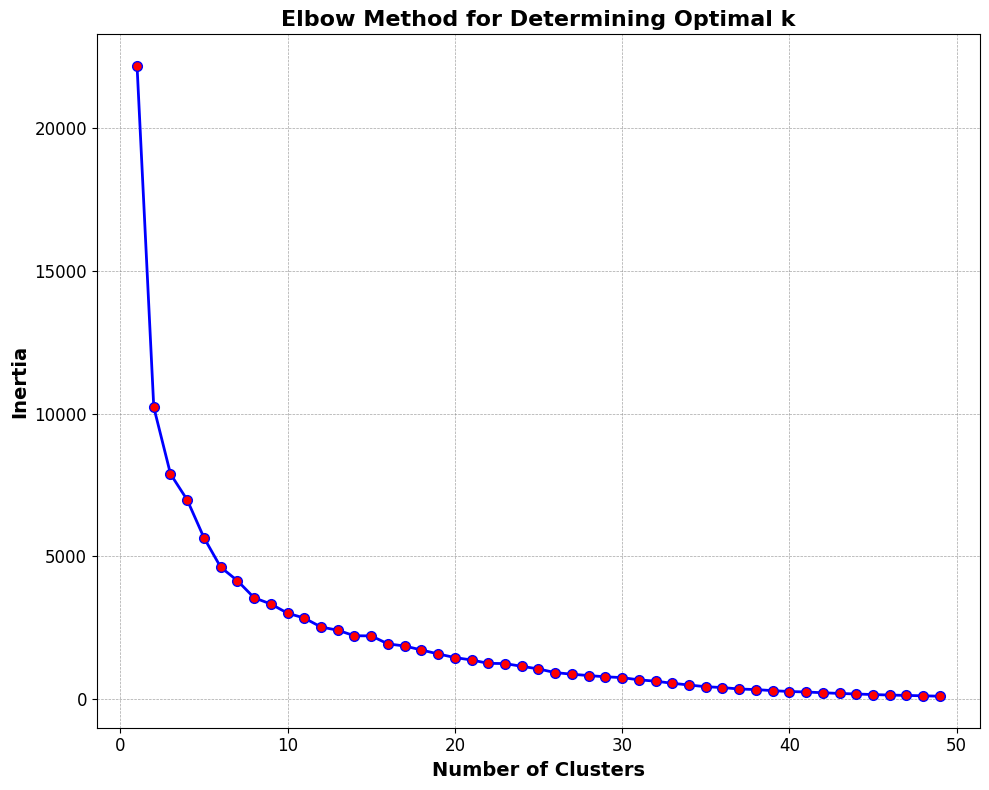

In [ ]:
# Set the size of the plot for better clarity and visibility
plt.figure(figsize=(10, 8))

# Plot inertia values against the number of clusters using a blue line with red markers
plt.plot(K, inertia, marker='o', linestyle='-', color='blue', linewidth=2, markersize=7, markerfacecolor='red')

# Set the label for the x-axis with specified font size and weight
plt.xlabel('Number of Clusters', fontsize=14, fontweight='bold')

# Set the label for the y-axis with specified font size and weight
plt.ylabel('Inertia', fontsize=14, fontweight='bold')

# Set the title of the plot with specified font size and weight
plt.title('Elbow Method for Determining Optimal k', fontsize=16, fontweight='bold')

# Enable grid lines for better readability, with specified style and color
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Set the font size of tick marks on the x-axis
plt.xticks(fontsize=12)

# Set the font size of tick marks on the y-axis
plt.yticks(fontsize=12)

# Adjust the layout to avoid any overlap of elements
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Initialize the KneeLocator to find the elbow point in the K-means inertia plot
knee_locator = KneeLocator(K, inertia, curve='convex', direction='decreasing')

# Extract the elbow point, which suggests the optimal number of clusters
optimal_clusters = knee_locator.elbow

# Print the optimal number of clusters as determined by the elbow method
print(f"The optimal number of clusters is: {optimal_clusters}")

The optimal number of clusters is: 8


In [ ]:
# Set the optimal number of clusters determined from previous analysis
optimal_clusters = 8

# Initialize the KMeans clustering algorithm with the specified number of clusters and a random state for reproducibility
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)

# Fit the KMeans model to the RFM data to perform the clustering
kmeans.fit(X)

# Assign the cluster labels generated by KMeans to a new column in the RFM DataFrame
rfm['Cluster'] = kmeans.labels_

# Print the count of customers in each cluster to see the distribution of the dataset across clusters
print(rfm['Cluster'].value_counts())

Cluster
3    1350
5     835
1     805
6     720
4     717
0     707
2     416
7     328
Name: count, dtype: int64


In [ ]:
# Group the RFM dataframe by 'Cluster' and calculate the average 'Recency' and 'Frequency',
# and both the average 'Monetary' value and count of entries in each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Print the aggregated cluster summary
print(cluster_summary)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         120.8      13.2    240.1   707
1          30.9      82.1   1144.5   805
2         485.8      43.2    681.2   416
3          27.1     403.5   9340.6  1350
4         285.3     161.2   2913.9   717
5         540.6      14.8    225.1   835
6         187.5      40.5    535.7   720
7         141.9      31.7   3341.8   328


                      Recency  Frequency  Monetary  CustomerCount
Segment                                                          
Casual Shoppers         187.5       40.5     535.7            720
Community Pillars        30.9       82.1    1144.5            805
Fresh Enthusiasts       120.8       13.2     240.1            707
Lost Legends            485.8       43.2     681.2            416
Occasional Splurgers    141.9       31.7    3341.8            328
Silent Browsers         540.6       14.8     225.1            835
Steady Patrons          285.3      161.2    2913.9            717
VIP Elites               27.1      403.5    9340.6           1350


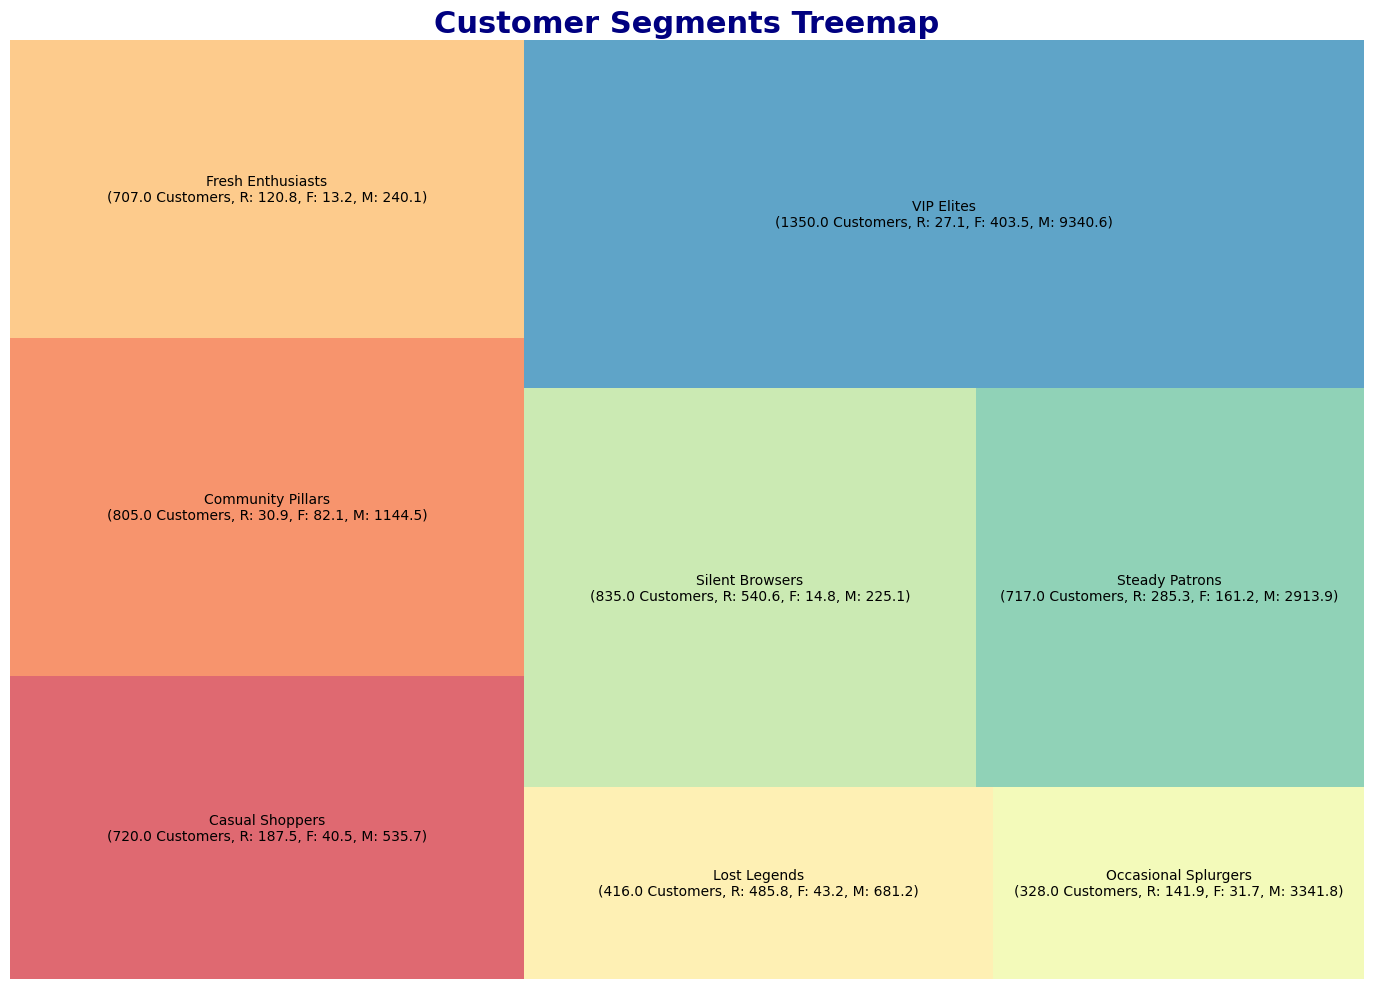

In [ ]:
# Assign descriptive names to each cluster for better readability and understanding
cluster_names = {
    0: 'Fresh Enthusiasts',
    1: 'Community Pillars',
    2: 'Lost Legends',
    3: 'VIP Elites',
    4: 'Steady Patrons',
    5: 'Silent Browsers',
    6: 'Casual Shoppers',
    7: 'Occasional Splurgers'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_names)  # Map numeric clusters to descriptive labels

# Aggregate RFM data by the newly created Segment labels to compute average Recency, Frequency, and Monetary values
segment_summary = (
    rfm
    .groupby('Segment')
    .agg({
        'Recency': 'mean',  # Average days since last purchase
        'Frequency': 'mean',  # Average number of transactions
        'Monetary': 'mean'  # Average spend amount
    })
    .round(1)  # Round the averages to one decimal place for simplicity
)
# Count the number of customers in each segment
segment_summary['CustomerCount'] = rfm.groupby('Segment').size()

# Print the summary table of segments
print(segment_summary)

# Plotting setup for the treemap visualization of customer segments
# Define a distinct color palette for the treemap
color_palette = sns.color_palette('Spectral', n_colors=len(segment_summary))

# Configure the size of the figure for the treemap
plt.figure(figsize=(14, 10))

# Create the treemap using squarify, mapping segment size and labels to the respective segment data
squarify.plot(
    sizes=segment_summary['CustomerCount'],
    label=[f"{segment}\n({row['CustomerCount']} Customers, R: {row['Recency']}, F: {row['Frequency']}, M: {row['Monetary']:.1f})"
           for segment, row in segment_summary.iterrows()],
    color=color_palette,
    alpha=0.8,
    pad=False
)

# Add a title to the treemap with customization for readability
plt.title("Customer Segments Treemap", fontsize=22, fontweight="bold", color='navy')

# Hide the axes for a cleaner visualization
plt.axis('off')

# Adjust layout to ensure labels are not truncated
plt.tight_layout()

# Display the treemap
plt.show()

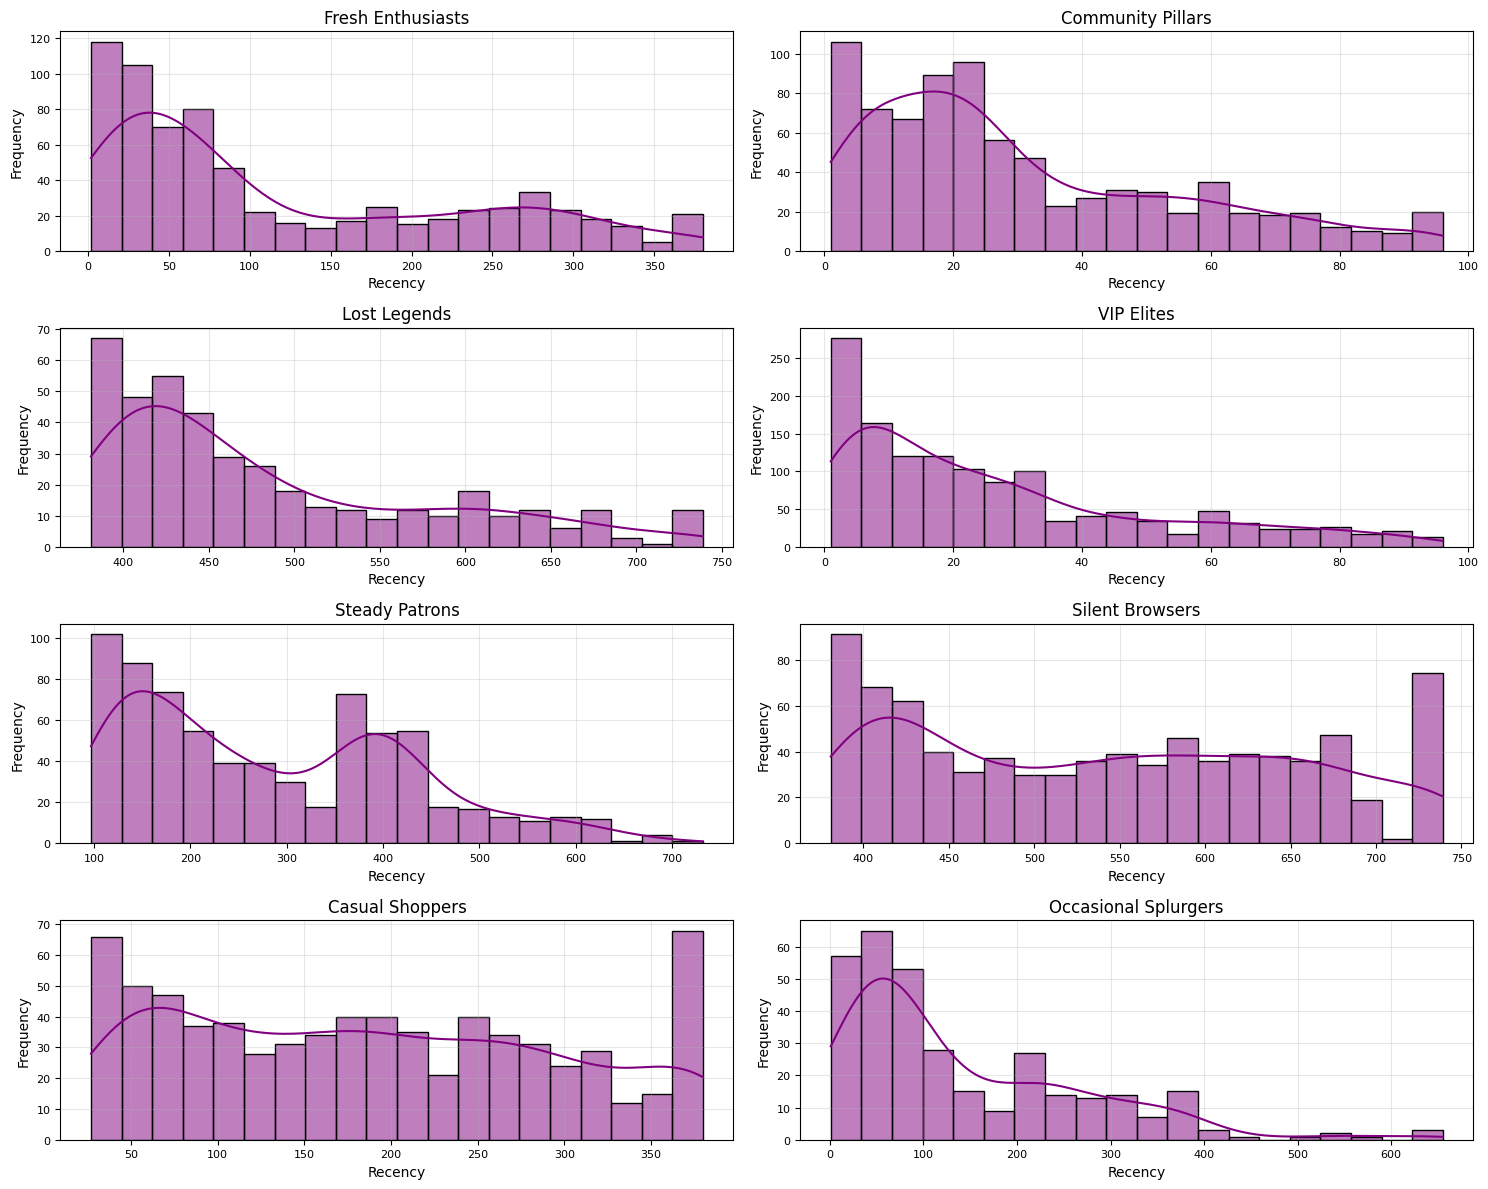

In [ ]:
# Define the total number of clusters for analysis
num_clusters = 8

# Calculate the number of rows needed in the subplot grid
num_rows = num_clusters // 2 if num_clusters % 2 == 0 else (num_clusters // 2 + 1)

# Initialize a figure with dynamic sizing based on the number of subplots needed
plt.figure(figsize=(15, num_rows * 3))

# Loop through each cluster to create individual histograms for the 'Recency' attribute
for cluster_id in range(num_clusters):
    # Create a subplot for each cluster
    ax = plt.subplot(num_rows, 2, cluster_id + 1)

    # Plot a histogram of 'Recency' for the current cluster with kernel density estimate
    sns.histplot(rfm[rfm['Cluster'] == cluster_id]['Recency'], bins=20, kde=True, color='purple')

    # Set the title of each subplot using the cluster's descriptive name, with fallback for unknown clusters
    plt.title(f'{cluster_names.get(cluster_id, "Unknown Cluster")}', fontsize=12)

    # Label the x-axis as 'Recency'
    plt.xlabel('Recency', fontsize=10)

    # Label the y-axis as 'Frequency'
    plt.ylabel('Frequency', fontsize=10)

    # Add grid lines to the plot for better readability, with reduced opacity
    plt.grid(True, alpha=0.3)

    # Adjust the size of tick labels for clarity
    ax.tick_params(axis='both', which='major', labelsize=8)

# Adjust the layout to ensure all subplot elements are clearly visible and non-overlapping
plt.tight_layout()

# Display the entire grid of histograms
plt.show()

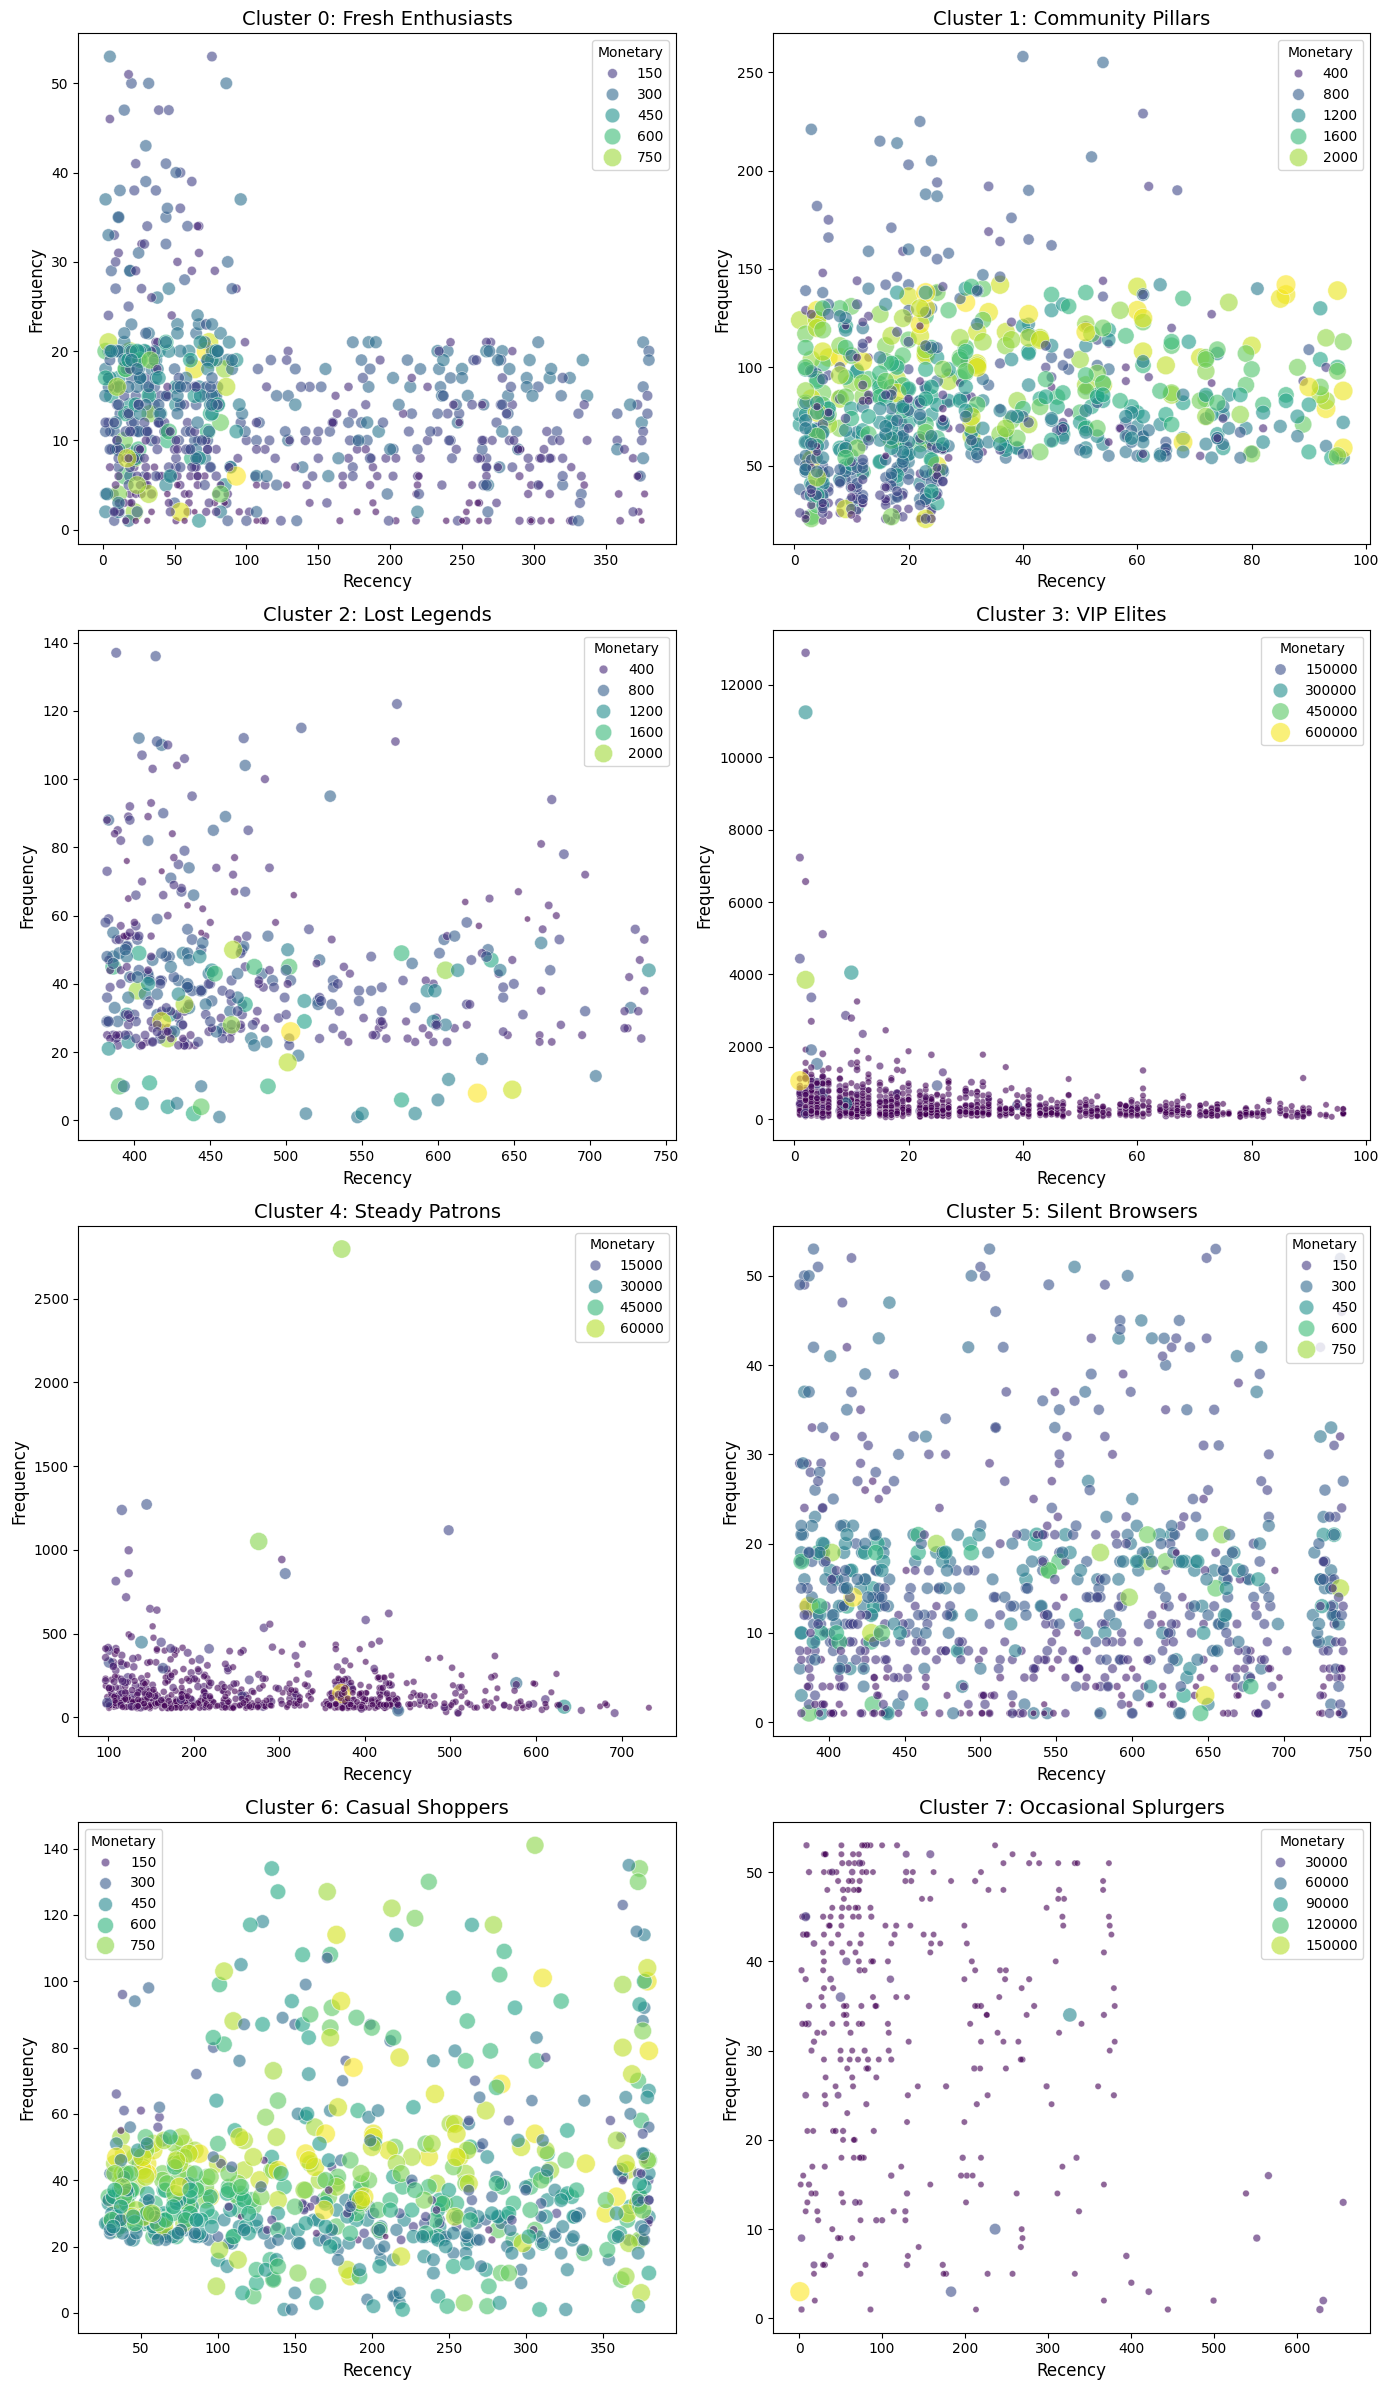

In [ ]:
# Define the total number of clusters for analysis
num_clusters = 8

# Calculate the number of rows needed for the subplot layout, ensuring there's an extra row if the number of clusters is odd
num_rows = (num_clusters + 1) // 2

# Create a figure with subplots arranged in rows and columns, adjusting the size for better visibility
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 24))

# Flatten the axes array for easier access in the loop
axes = axes.ravel()

# Initialize a list to collect legend elements for a common legend after plotting
legend_elements = []

# Loop through each cluster to plot the RFM data
for cluster_id in range(num_clusters):
    # Filter the data for the current cluster
    cluster_data = rfm[rfm['Cluster'] == cluster_id]

    # Plot a scatterplot for the current cluster's data, mapping Recency to x-axis, Frequency to y-axis,
    # and using Monetary value for color and size of the points
    ax = sns.scatterplot(
        data=cluster_data,
        x='Recency',
        y='Frequency',
        hue='Monetary',
        size='Monetary',
        sizes=(20, 200),
        palette='viridis',
        alpha=0.6,
        ax=axes[cluster_id]
    )

    # Set the title for the subplot using the predefined cluster name, enhancing readability with font size adjustments
    axes[cluster_id].set_title(f'Cluster {cluster_id}: {cluster_names[cluster_id]}', fontsize=14)

    # Set axis labels with adjusted font size for clarity
    axes[cluster_id].set_xlabel('Recency', fontsize=12)
    axes[cluster_id].set_ylabel('Frequency', fontsize=12)

    # Collect legend handles and labels from the last plot if it's the last iteration, for later use in a common legend
    if cluster_id == num_clusters - 1:
        legend_elements = ax.get_legend_handles_labels()

# If the number of clusters is odd, hide the last subplot to prevent an empty plot from displaying
if num_clusters % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust the layout to ensure there's no overlap of subplot elements
plt.tight_layout()

# Show the final plot
plt.show()

In [ ]:
# Merge RFM and Clusters with original data
data_with_rfm = data.merge(rfm, on='Customer ID')

# Examine unique values in the 'StockCode' column
unique_stock_codes = data_with_rfm['StockCode'].unique()

# Encode users
user_encoder = LabelEncoder()
data_with_rfm['user_id'] = user_encoder.fit_transform(data_with_rfm['Customer ID'])

# Convert all values in the 'StockCode' column to strings
data_with_rfm['StockCode'] = data_with_rfm['StockCode'].astype(str)

# Encode items
item_encoder = LabelEncoder()
data_with_rfm['item_id'] = item_encoder.fit_transform(data_with_rfm['StockCode'])

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Calculate the global average 'quantity' for each item across all users
item_global_avg = data_with_rfm.groupby('item_id')['Quantity'].mean()

# Predict the top N items for all users based on global average quantity
# Here, N is set to the average number of items per user but you can set a different threshold
N = int(data_with_rfm.groupby('user_id').size().mean())

# Get the item indices sorted by global average quantity
top_N_items = item_global_avg.nlargest(N).index.tolist()

# Create a dictionary where the key is the user_id and the value is the top N items
baseline_recommendations = {user_id: top_N_items for user_id in data_with_rfm['user_id'].unique()}

# Split the original data into training and test sets
train_data, test_data = train_test_split(data_with_rfm, test_size=0.3, random_state=42)

# Create a function to calculate true positives for a user
def calculate_true_positives(user_id, true_items, predicted_items):
    # True items are the items in the test set
    true_items_set = set(true_items)
    # Predicted items are the top N items from the baseline
    predicted_items_set = set(predicted_items)
    # True positives are the intersection of the two sets
    return len(true_items_set & predicted_items_set)

# Calculate the number of true positives for each user in the test set
true_positives = test_data.groupby('user_id').apply(lambda x: calculate_true_positives(x.name, x['item_id'], baseline_recommendations[x.name]))

# Calculate precision, recall, and F1-score for the baseline
# Note: We assume binary relevance; an item is relevant if it's one of the purchased items in the test set
precision = true_positives.sum() / (N * len(baseline_recommendations))
recall = true_positives.sum() / test_data.groupby('user_id')['item_id'].nunique().sum()
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Baseline Precision: {precision}')
print(f'Baseline Recall: {recall}')
print(f'Baseline F1-Score: {f1}')

Baseline Precision: 0.0025456794232111323
Baseline Recall: 0.010827026370411058
Baseline F1-Score: 0.004122148302831111


In [ ]:
# Aggregate the purchase frequency and create the interaction matrix
interaction_matrix = data_with_rfm.groupby(['user_id', 'item_id'])['Frequency'].sum().unstack(fill_value=0)

# Normalize the interaction matrix
max_freq = interaction_matrix.max().max()
interactions_scaled = torch.FloatTensor(interaction_matrix.values / max_freq)

In [ ]:
# Split data into training and validation sets
num_users = interactions_scaled.shape[0]
train_indices, val_indices = train_test_split(range(num_users), test_size=0.2, random_state=42)

In [ ]:
class EnhancedCFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=100):
        super(EnhancedCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.fc1 = nn.Linear(embedding_size, 100)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_items)

    # Generate embeddings for input user IDs
    def forward(self, user_ids):
        user_embedding = self.user_embedding(user_ids)
        x = self.relu(self.fc1(user_embedding))
        x = self.dropout(x)
        scores = self.fc2(x)
        return scores

In [ ]:
# Initialize model
num_items = interactions_scaled.shape[1]
model = EnhancedCFModel(num_users, num_items)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Metrics and storage
train_losses, val_losses = [], []

 # Training settings
epochs = 50
best_val_loss = float('inf')
patience, trials = 3, 0

In [ ]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_predictions = model(torch.tensor(train_indices, dtype=torch.long))
    train_loss = criterion(train_predictions, interactions_scaled[train_indices])
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    train_losses.append(train_loss.item())


    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        val_predictions = model(torch.tensor(val_indices, dtype=torch.long))
        val_loss = criterion(val_predictions, interactions_scaled[val_indices])
        val_losses.append(val_loss.item())

    # Output training progress
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}')

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        trials = 0
    else:
        # Increment trials counter if validation loss didn't improve
        trials += 1
        # Stop early if no improvement in a given number of epochs
        if trials >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50, Train Loss: 0.11742421239614487, Val Loss: 0.02818826399743557
Epoch 2/50, Train Loss: 0.06233350560069084, Val Loss: 0.019733887165784836
Epoch 3/50, Train Loss: 0.039873071014881134, Val Loss: 0.013094854541122913
Epoch 4/50, Train Loss: 0.02507246658205986, Val Loss: 0.008581731468439102
Epoch 5/50, Train Loss: 0.01596822962164879, Val Loss: 0.005781188141554594
Epoch 6/50, Train Loss: 0.010516711510717869, Val Loss: 0.004081488121300936
Epoch 7/50, Train Loss: 0.007386640179902315, Val Loss: 0.0030340731609612703
Epoch 8/50, Train Loss: 0.0053344122134149075, Val Loss: 0.002371649956330657
Epoch 9/50, Train Loss: 0.004087537992745638, Val Loss: 0.0019379635341465473
Epoch 10/50, Train Loss: 0.0032615517266094685, Val Loss: 0.0016430941177532077
Epoch 11/50, Train Loss: 0.0027144772466272116, Val Loss: 0.001434303936548531
Epoch 12/50, Train Loss: 0.002324140165001154, Val Loss: 0.001280389609746635
Epoch 13/50, Train Loss: 0.0020507951267063618, Val Loss: 0.001162675209

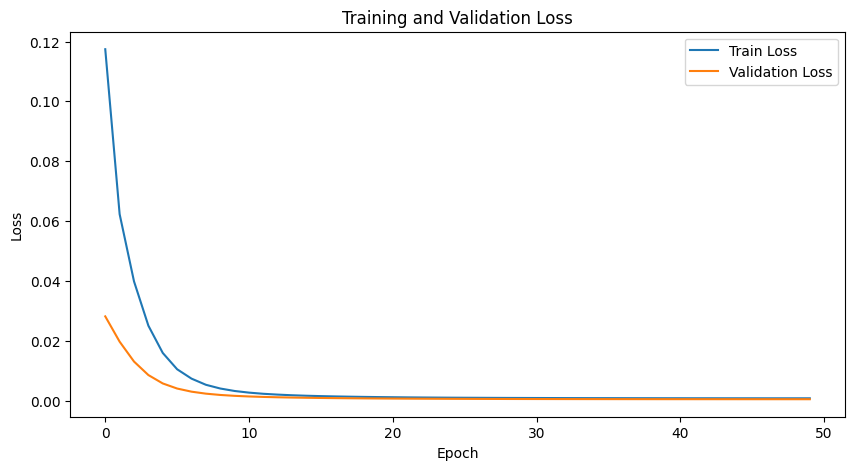

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
rmse = torch.sqrt(criterion(val_predictions, interactions_scaled[val_indices])).item()
print(f'Validation RMSE: {rmse}')


Validation RMSE: 0.02263391576707363


In [ ]:
# Assuming binary classification with a threshold
threshold = 0.5
predicted_labels = (val_predictions >= threshold).int()
true_labels = (interactions_scaled[val_indices] > 0).int()

# Calculate precision, recall, and F1-score using sklearn's functions
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels.view(-1).cpu(), predicted_labels.view(-1).cpu(), average='macro')
recall = recall_score(true_labels.view(-1).cpu(), predicted_labels.view(-1).cpu(), average='macro')
f1 = f1_score(true_labels.view(-1).cpu(), predicted_labels.view(-1).cpu(), average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.4915660984756675
Recall: 0.5
F1-Score: 0.4957471813844292


In [ ]:
model.eval()
with torch.no_grad():
    # Generate predictions for all users
    all_predictions = model(torch.arange(num_users))
    # Get the indices of the top five recommended items for each user
    top_five_items = torch.topk(all_predictions, 5, dim=1)[1]

# Convert numeric item indices to actual item StockCodes
top_five_products = [item_encoder.inverse_transform(items.numpy()) for items in top_five_items]

def get_recommendations(customer_id):
    # Check if the customer exists in the dataset
    if customer_id not in data_with_rfm['Customer ID'].values:
        print(f"Customer ID {customer_id} not found. Providing default recommendations.")
        # Provide default recommendations if customer ID is not found
        default_recommendations = item_encoder.inverse_transform(np.argsort(-all_predictions.mean(dim=0).numpy())[:5])
        return None, default_recommendations  # Return no cluster info

    # Retrieve cluster assignment for the customer
    cluster = data_with_rfm[data_with_rfm['Customer ID'] == customer_id]['Cluster'].iloc[0]

    # Find the user index for recommendation
    user_index = user_encoder.transform([customer_id])[0]
    # Get the top five recommended products for this user
    recommendations = top_five_products[user_index]
    return cluster, recommendations

In [ ]:
# Example usage: Request recommendations for a specific customer
customer_id = 13078  # Replace this with any customer ID to get 5 recommendation products
recommendation_info = get_recommendations(customer_id)
if recommendation_info:
    # Print the recommendations if available
    cluster, recommended_products = recommendation_info
    print(f'Customer ID: {customer_id}, Cluster: {cluster}, Recommended Products: {recommended_products}')
else:
    # Handle cases where recommendations cannot be generated
    print("Recommendation could not be generated.")

Customer ID: 13078, Cluster: 3, Recommended Products: ['84707B' '84795B' '90040B' '23137' '84666']
